In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import vincenty
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
import eli5
from eli5.sklearn import PermutationImportance
from skopt.space import Real
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**4 Business questions to ask with Airbnb data:**

* **(Q1)** what are the positive and negative reviews (based on review text); 
* **(Q2)** what are the main distinctions of Airbnb superhosts from ordinary hosts;
* **(Q3)** what are the main factors that influence Airbnb renting price;
* **(Q4)** how well can we predict the Airbnb renting price based on the data from a different city. 

To answer all these questions, I have downloaded [the recent Airbnb apartment listings](http://insideairbnb.com/get-the-data.html) for August 2018.

It takes several seconds to download approx. 133 MBytes of archived listings and reviews from Aug 2018 on Boston (MA, USA), Seattle (WA, USA) and Copenhagen (Denmark, Europe):

In [2]:
%%time
! rm -r data.insideairbnb.com
# Seattle data:
! wget -xq http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz
! wget -xq http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz
# Boston data:
! wget -xq http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz
! wget -xq http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz
# Copenhagen data:
! wget -xq http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/listings.csv.gz
! wget -xq http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/reviews.csv.gz

! du -sh data.insideairbnb.com 

133M	data.insideairbnb.com
CPU times: user 1.34 s, sys: 361 ms, total: 1.7 s
Wall time: 26.9 s


Open the data as `pandas` Dataframes:

In [3]:
seattle_path = 'data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/'
seattle_reviews =  pd.read_csv(seattle_path + 'reviews.csv.gz')
seattle_listings = pd.read_csv(seattle_path + 'listings.csv.gz')

In [4]:
boston_path = 'data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/'
boston_reviews =  pd.read_csv(boston_path + 'reviews.csv.gz')
boston_listings = pd.read_csv(boston_path + 'listings.csv.gz')

In [5]:
copenhagen_path = 'data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/'
copenhagen_reviews =  pd.read_csv(copenhagen_path + 'reviews.csv.gz')
copenhagen_listings = pd.read_csv(copenhagen_path + 'listings.csv.gz')

# Data preprocessing

## First, we need to look on *_reviews:

In [6]:
boston_reviews.shape, seattle_reviews.shape, copenhagen_reviews.shape

((177559, 6), (344065, 6), (323658, 6))

In [7]:
boston_reviews.info(max_cols=20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177559 entries, 0 to 177558
Data columns (total 6 columns):
listing_id       177559 non-null int64
id               177559 non-null int64
date             177559 non-null object
reviewer_id      177559 non-null int64
reviewer_name    177559 non-null object
comments         177361 non-null object
dtypes: int64(3), object(3)
memory usage: 8.1+ MB


In [8]:
seattle_reviews.sample(20, random_state=42) # note that 42 is the answer for everything :-)

,listing_id,id,date,reviewer_id,reviewer_name,comments
323321,21883885,243650573,2018-03-16,126168643,Julio,Very conveniently placed location. Other than ...
250677,15435193,148944528,2017-05-01,54633845,Olivia,"The room was very clean and comfortable, as wa..."
136580,7411863,75200129,2016-05-19,57563701,Yuesong,A good experience! Julian is very kind!!!! And...
100160,5174876,43756612,2015-08-22,32841859,Kristjana,I live in the neighborhood and when my whole f...
252240,15537773,173137916,2017-07-22,50079968,Robert,"Clean, comfortable multi-family home close to ..."
295115,19364598,198529335,2017-09-29,20034634,Rich,Eric is super cordial and warm. The location i...
30171,1003469,270281789,2018-05-28,10153172,Beck,Great location and space! Steven was very resp...
288730,18733199,171092727,2017-07-16,61328468,Apryl,James was a great host! He responded to all my...
9720,193836,290086330,2018-07-13,40845129,Yuan,Amy and Nathan are extremely friendly. kids a...
173006,9698202,136970826,2017-03-12,4447497,Alexander,"A great spot, excellent communication and just..."


In [9]:
boston_reviews.sample(20, random_state=42)

,listing_id,id,date,reviewer_id,reviewer_name,comments
149527,19676676,193222953,2017-09-12,116471884,Shelley,Fiona's apartment is so much more than adverti...
57968,6300089,171043397,2017-07-16,128756927,Sarah,Irida was a great host and her apartment was c...
98689,13378923,187823962,2017-08-27,126891761,David,We thoroughly enjoyed our stay. Kathe and Lisa...
30936,2701124,254668379,2018-04-17,4704201,Sam,We stayed at Varouj's apartment for Marathon w...
123931,16238114,144069970,2017-04-14,12549902,Elizabeth,Really comfortable cozy apartment in a great a...
160750,21346776,243571913,2018-03-16,103625046,Rio,Matthew is very precise with his instructions ...
22988,1584362,132857678,2017-02-19,25203627,Ososanya,"Absolutely beautiful home, cleaner than almost..."
71329,8065282,200207390,2017-10-04,65788783,Zach,"It was a very nice, easy place to stay!"
32792,2931165,81956860,2016-06-26,61109757,Ramya + Tucker,Cynthia and her family were so welcoming. We h...
119465,15521407,299233493,2018-07-30,33131420,Anna,Good host. Clean space. Beautiful home and bac...


In [10]:
copenhagen_reviews.sample(20, random_state=42)

,listing_id,id,date,reviewer_id,reviewer_name,comments
169321,9111211,71515076,2016-04-25,37666249,Anthony,"Rasmus' apartment is incredible, it's in a gre..."
237465,15337225,218694016,2017-12-14,50188804,Kristiina,"Very nice, cozy flat. Good location in Østerbr..."
7123,353025,13488683,2014-05-28,766215,Matthew,Ben's place was wonderful during our 10-day st...
189419,11536155,114522588,2016-11-19,6075818,Victoria,Jakob so kindly hosted me very last minute in ...
281056,19527393,164581460,2017-06-28,82712115,Deividas,The host canceled this reservation 39 days bef...
8186,421110,58685724,2016-01-03,2527400,Sebastian,Everything was fine. The flat is exactly like ...
158410,8074752,243519351,2018-03-16,118425341,Becky,Thomas's place has two extra-great perks: 1)be...
260356,17820007,158099065,2017-06-05,56220911,Marie- Theres,Very fancy appartment!!! \n
247551,16550558,154121546,2017-05-23,3243989,Gareth,The flat is in a lively location near bars and...
187586,11329621,141479162,2017-04-03,8608348,Craig,"We had a great stay at the apartment, it was p..."


Note that some reviews are not in English! E.g., there are some reviews in German, Danish, Swedish.

## Then, we need to look on *_listings:

In [11]:
seattle_listings.shape, boston_listings.shape, copenhagen_listings.shape

((8494, 96), (6036, 96), (26202, 96))

As we see, there are much more columns than in `*_reviews`, so we need combine them and preprocess appropriately:

In [12]:
all_listings = pd.concat([seattle_listings, boston_listings, copenhagen_listings],
                        keys = [1, 2, 3])
all_listings.reset_index(level=0, inplace=True)
all_listings.rename(columns={'level_0': 'city_index'}, inplace=True)

In [13]:
all_listings.head(2)

,city_index,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,1,2318,https://www.airbnb.com/rooms/2318,20180816121209,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,"We are a family of three, who live next door a...",four day minimum stay,NaN,NaN,https://a0.muscache.com/im/pictures/ac08892c-f...,NaN,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",We love travel and adventure! We have stayed i...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/36c67...,https://a0.muscache.com/im/pictures/user/36c67...,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.610819,-122.290816,t,House,Entire home/apt,8,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,$296.00,NaN,NaN,$500.00,$275.00,8,$20.00,4,300,2 days ago,t,3,30,60,329,2018-08-16,19,2008-09-15,2018-06-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
1,1,4291,https://www.airbnb.com/rooms/4291,20180816121209,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,NaN,NaN,"We do not live on the property, however we do ...",We ask that you please use nearby street parki...,NaN,NaN,https://a0.muscache.com/im/pictures/19407574/6...,NaN,35749,https://www.airbnb.com/users/show/35749,Jess & Joey,2009-09-02,"Seattle, Washington, United States",We're a former Seattle couple who just couldn'...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/a3c77...,https://a0.muscache.com/im/pictures/user/a3c77...,Roosevelt,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Seattle, WA, United States",Roosevelt,Roosevelt,Other neighborhoods,Seattle,WA,98115,Seattle,"Seattle, WA",US,United States,47.687801,-122.313427,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",NaN,$82.00,$525.00,"$1,925.00",NaN,$30.00,1,$0.00,2,60,2 weeks ago,t,13,43,73,348,2018-08-16,57,2013-07-01,2018-08-01,91.0,9.0,9.0,10.0,9.0,9.0,9.0,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91


In [14]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40732 entries, 0 to 26201
Data columns (total 97 columns):
city_index                          40732 non-null int64
id                                  40732 non-null int64
listing_url                         40732 non-null object
scrape_id                           40732 non-null int64
last_scraped                        40732 non-null object
name                                40651 non-null object
summary                             39340 non-null object
space                               26306 non-null object
description                         40425 non-null object
experiences_offered                 40732 non-null object
neighborhood_overview               23380 non-null object
notes                               15360 non-null object
transit                             24787 non-null object
access                              22319 non-null object
interaction                         21721 non-null object
house_rules             

First, we look the columns with zero non-null values:

In [15]:
unique_nums = all_listings.nunique()
masked_columns = [col for col in all_listings.columns if unique_nums[col] == 0]
masked_columns

['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate']

Column `license` is not informative, so I drop it as well:

In [16]:
Counter(all_listings.license.dropna())

Counter({'81-5461832': 4, 37468959.0: 2})

In [17]:
masked_columns.append('license')

Look other columns for more details:

In [18]:
all_listings.head(2)

,city_index,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,1,2318,https://www.airbnb.com/rooms/2318,20180816121209,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,"We are a family of three, who live next door a...",four day minimum stay,NaN,NaN,https://a0.muscache.com/im/pictures/ac08892c-f...,NaN,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",We love travel and adventure! We have stayed i...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/36c67...,https://a0.muscache.com/im/pictures/user/36c67...,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.610819,-122.290816,t,House,Entire home/apt,8,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,$296.00,NaN,NaN,$500.00,$275.00,8,$20.00,4,300,2 days ago,t,3,30,60,329,2018-08-16,19,2008-09-15,2018-06-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
1,1,4291,https://www.airbnb.com/rooms/4291,20180816121209,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,NaN,NaN,"We do not live on the property, however we do ...",We ask that you please use nearby street parki...,NaN,NaN,https://a0.muscache.com/im/pictures/19407574/6...,NaN,35749,https://www.airbnb.com/users/show/35749,Jess & Joey,2009-09-02,"Seattle, Washington, United States",We're a former Seattle couple who just couldn'...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/a3c77...,https://a0.muscache.com/im/pictures/user/a3c77...,Roosevelt,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Seattle, WA, United States",Roosevelt,Roosevelt,Other neighborhoods,Seattle,WA,98115,Seattle,"Seattle, WA",US,United States,47.687801,-122.313427,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",NaN,$82.00,$525.00,"$1,925.00",NaN,$30.00,1,$0.00,2,60,2 weeks ago,t,13,43,73,348,2018-08-16,57,2013-07-01,2018-08-01,91.0,9.0,9.0,10.0,9.0,9.0,9.0,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91


As we see, it is worth to drop columns such as `id`, `listing_url`, `scrape_id`, `picture_url`, `host_url`, `host_thumbnail_url`, `host_picture_url`:

In [19]:
masked_columns += ['id', 
                   'listing_url', 
                   'scrape_id', 
                   'host_id',
                   'picture_url', 
                   'host_url', 
                   'host_thumbnail_url', 
                   'host_picture_url']

In [20]:
all_listings.drop(masked_columns, axis=1, inplace=True)

Some categorical columns need to be converted into numeric. For example, look on price columns, they are categorical because of '$' sign before the total price:

In [21]:
price_cols = ['price', 
              'weekly_price', 
              'monthly_price', 
              'security_deposit', 
              'cleaning_fee', 
              'extra_people']

In [22]:
all_listings.head(1).price.values

array(['$296.00'], dtype=object)

In [23]:
s1 = '$296.00'

In [24]:
prices_to_numbers = lambda s: float(str(s).replace(',', '').split('$')[-1])
prices_to_numbers(s1)

296.0

In [25]:
for col in price_cols:
    print(col)
    all_listings[col] = all_listings[col].apply(prices_to_numbers)

price
weekly_price
monthly_price
security_deposit
cleaning_fee
extra_people


In [26]:
all_listings.head(2)

,city_index,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,1,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,"We are a family of three, who live next door a...",four day minimum stay,Megan,2008-08-26,"Seattle, Washington, United States",We love travel and adventure! We have stayed i...,within an hour,100%,f,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.610819,-122.290816,t,House,Entire home/apt,8,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,296.0,NaN,NaN,500.0,275.0,8,20.0,4,300,2 days ago,t,3,30,60,329,2018-08-16,19,2008-09-15,2018-06-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
1,1,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,NaN,NaN,"We do not live on the property, however we do ...",We ask that you please use nearby street parki...,Jess & Joey,2009-09-02,"Seattle, Washington, United States",We're a former Seattle couple who just couldn'...,within an hour,100%,f,Roosevelt,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Seattle, WA, United States",Roosevelt,Roosevelt,Other neighborhoods,Seattle,WA,98115,Seattle,"Seattle, WA",US,United States,47.687801,-122.313427,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",NaN,82.0,525.0,1925.0,NaN,30.0,1,0.0,2,60,2 weeks ago,t,13,43,73,348,2018-08-16,57,2013-07-01,2018-08-01,91.0,9.0,9.0,10.0,9.0,9.0,9.0,f,{WASHINGTON},f,f,moderate,f,f,5,0.91


Also, some of the categorical columns are in fact Boolean and require conversion:

In [27]:
boolean_cols = ['host_is_superhost', 
               'host_has_profile_pic',
               'host_identity_verified',
               'is_location_exact',
               'has_availability',
               'requires_license',
               'instant_bookable',
               'is_business_travel_ready',
               'require_guest_profile_picture',
               'require_guest_phone_verification']

In [28]:
def booleans_to_numbers(s):
    if s == 'f':
        return 0
    elif s == 't':
        return 1
    return None

In [29]:
for col in boolean_cols:
    print(col)
    all_listings[col] = all_listings[col].apply(booleans_to_numbers)

host_is_superhost
host_has_profile_pic
host_identity_verified
is_location_exact
has_availability
requires_license
instant_bookable
is_business_travel_ready
require_guest_profile_picture
require_guest_phone_verification


In [30]:
all_listings.select_dtypes(object).head(2)

,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_neighbourhood,host_verifications,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,property_type,room_type,bed_type,amenities,calendar_updated,calendar_last_scraped,first_review,last_review,jurisdiction_names,cancellation_policy
0,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,"We are a family of three, who live next door a...",four day minimum stay,Megan,2008-08-26,"Seattle, Washington, United States",We love travel and adventure! We have stayed i...,within an hour,100%,Minor,"['email', 'phone', 'reviews', 'jumio', 'govern...","Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,House,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",2 days ago,2018-08-16,2008-09-15,2018-06-25,{WASHINGTON},strict_14_with_grace_period
1,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,NaN,NaN,"We do not live on the property, however we do ...",We ask that you please use nearby street parki...,Jess & Joey,2009-09-02,"Seattle, Washington, United States",We're a former Seattle couple who just couldn'...,within an hour,100%,Roosevelt,"['email', 'phone', 'facebook', 'reviews', 'kba']","Seattle, WA, United States",Roosevelt,Roosevelt,Other neighborhoods,Seattle,WA,98115,Seattle,"Seattle, WA",US,United States,House,Private room,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",2 weeks ago,2018-08-16,2013-07-01,2018-08-01,{WASHINGTON},moderate


First, we will not use textual description columns and datetime columns (except `date_scraped` and `host_since`, which will be used to calculate host experience), it is time to drop them:

In [31]:
textual_datetime_cols = ['name',
                        'summary',
                        'space',
                        'description',
                        'neighborhood_overview',
                        'notes',
                        'transit',
                        'access',
                        'interaction',
                        'host_name',
                        'host_location',
                        'host_about',
                        'host_neighbourhood',
                        'street',
                        'neighbourhood',
                        'neighbourhood_cleansed',
                        'neighbourhood_group_cleansed',
                        'state',
                        'zipcode',
                        'market',
                        'smart_location',
                        'city',
                        'country_code',
                        'country', 
                        'calendar_updated', 
                        'calendar_last_scraped', 
                        'first_review',
                        'last_review', 
                        'jurisdiction_names',
                        'experiences_offered']

In [32]:
all_listings.drop(textual_datetime_cols, axis=1, inplace=True)

In [33]:
all_listings.head(2)

,city_index,last_scraped,house_rules,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,1,2018-08-16,four day minimum stay,2008-08-26,within an hour,100%,0.0,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1.0,1.0,47.610819,-122.290816,1,House,Entire home/apt,8,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,296.0,NaN,NaN,500.0,275.0,8,20.0,4,300,1,3,30,60,329,19,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,strict_14_with_grace_period,0,0,2,0.16
1,1,2018-08-16,We ask that you please use nearby street parki...,2009-09-02,within an hour,100%,0.0,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,1.0,47.687801,-122.313427,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",NaN,82.0,525.0,1925.0,NaN,30.0,1,0.0,2,60,1,13,43,73,348,57,91.0,9.0,9.0,10.0,9.0,9.0,9.0,0,0,0,moderate,0,0,5,0.91


Then, we look on individual features for more details.

For example, `host_response_time` is ordinal (ordered categorical) feature, it makes sence to transform it to integers:

In [34]:
all_listings.host_response_time.unique()

array(['within an hour', 'within a few hours', 'within a day',
       'a few days or more', nan], dtype=object)

In [35]:
host_response_dict = {'within an hour': 1, 
                      'within a few hours': 2, 
                      'within a day': 3,
                     'a few days or more': 4}

all_listings.host_response_time.replace(host_response_dict, inplace=True)

Next, we are interested to write the difference between features `last_scraped` and `host_since` into a new feature, `host_experience`, and drop the initial features:

In [36]:
all_listings.last_scraped.head(2).values

array(['2018-08-16', '2018-08-16'], dtype=object)

In [37]:
all_listings.dropna(axis=0, how='any', subset=['host_since'], inplace=True)
all_listings['host_experience'] = all_listings.last_scraped.apply(lambda s: parser.parse(s)) - all_listings.host_since.apply(lambda s: parser.parse(s))
all_listings.host_experience = all_listings.host_experience.astype(str).apply(lambda s: int(s.split(' ')[0]))

In [38]:
all_listings.drop(['last_scraped', 'host_since'], axis=1, inplace=True)

In [39]:
all_listings.head(2)

,city_index,house_rules,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_experience
0,1,four day minimum stay,1.0,100%,0.0,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1.0,1.0,47.610819,-122.290816,1,House,Entire home/apt,8,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,296.0,NaN,NaN,500.0,275.0,8,20.0,4,300,1,3,30,60,329,19,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,strict_14_with_grace_period,0,0,2,0.16,3642
1,1,We ask that you please use nearby street parki...,1.0,100%,0.0,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,1.0,47.687801,-122.313427,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",NaN,82.0,525.0,1925.0,NaN,30.0,1,0.0,2,60,1,13,43,73,348,57,91.0,9.0,9.0,10.0,9.0,9.0,9.0,0,0,0,moderate,0,0,5,0.91,3270


Then, we extract some meaningful information from `house_rules`:

In [40]:
all_listings.house_rules.head(50)

0                                 four day minimum stay
1     We ask that you please use nearby street parki...
2     **PLEASE READ** NO SMOKING NO VAPING NO MARIJU...
3     Please treat the cottage as if it were your ow...
4     No drugs,no smoking inside *outside in front o...
5     Dear Prospective Guest,   There aren’t really ...
6     *The Sweet Orange is a No Smoking house.  The ...
7     *The Tangerine Dream is a Non-Smoking house an...
8     Please treat the apartment as if it were your ...
9     You agree to the following terms and condition...
10    Clean up after yourself in the Kitchen and Bat...
11    We ask that you please use nearby street parki...
12    We ask that you use adjacent street parking, b...
13    no smoking.recycle, do unto others.. treat thi...
14    We ask that you use nearby street parking, but...
15    Consideration for others is the name of the ga...
16    Consideration for others is the name of the ga...
17    While staying with us, we welcome you to s

For example, no smoking and no pets are often requied, so it is good to contain special features for such apartments:

In [41]:
no_smoking = lambda s: int('no smoking' in str(s).lower() or 'smoking is not allowed' in str(s).lower())  
no_pets = lambda s: int('no pets' in str(s).lower() or 'no smoking or pets' in str(s).lower())

In [42]:
all_listings['house_rules_no_smoking'] = all_listings.house_rules.apply(no_smoking)
all_listings['house_rules_no_pets'] = all_listings.house_rules.apply(no_pets)

In [43]:
all_listings.drop(['house_rules'], axis=1, inplace=True)

Let us look on `host_verifications` column:

In [44]:
all_listings.host_verifications.head(10).values

array(["['email', 'phone', 'reviews', 'jumio', 'government_id']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'manual_online', 'reviews', 'manual_offline', 'jumio', 'offline_government_id', 'kba', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio', 'government_id']",
       "['email', 'phone', 'reviews', 'kba', 'work_email']",
       "['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']"],
      dtype=object)

It makes sense to count the number of different verifications and to create a new feature, `host_verification_level`:

In [45]:
all_listings['host_verification_level'] = all_listings.host_verifications.apply(lambda s: len(s.split(', ')))

In [46]:
all_listings.host_verification_level.describe()

count    40723.000000
mean         4.955553
std          1.986457
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         13.000000
Name: host_verification_level, dtype: float64

In [47]:
all_listings.drop(['host_verifications'], axis=1, inplace=True)

Then, we simply drop the columns `property_type`, `bed_type` and `cancellation_policy`:

In [48]:
all_listings.property_type.unique()

array(['House', 'Guest suite', 'Apartment', 'Condominium', 'Guesthouse',
       'Cabin', 'Townhouse', 'Bungalow', 'Loft', 'Cottage',
       'Bed and breakfast', 'Boat', 'Serviced apartment', 'Castle',
       'Houseboat', 'Hostel', 'Camper/RV', 'Tent', 'Other', 'Tiny house',
       'Treehouse', 'Yurt', 'Aparthotel', 'Chalet', 'Villa', 'Lighthouse',
       'Earth house', 'Boutique hotel', 'Hut', 'Resort', 'Bus',
       'Nature lodge', 'In-law', 'Casa particular (Cuba)', 'Hotel',
       'Island', 'Casa particular', 'Dammuso (Italy)'], dtype=object)

In [49]:
all_listings.bed_type.unique()

array(['Real Bed', 'Futon', 'Pull-out Sofa', 'Airbed', 'Couch'],
      dtype=object)

In [50]:
all_listings.cancellation_policy.unique()

array(['strict_14_with_grace_period', 'moderate', 'flexible',
       'super_strict_60', 'strict', 'super_strict_30'], dtype=object)

In [51]:
all_listings.drop(['property_type', 'bed_type', 'cancellation_policy'], axis=1, inplace=True)

Column `host_response_rate` can be easily converted to numerical `host_response_fraction`:

In [52]:
all_listings.host_response_rate.unique()

array(['100%', '94%', '99%', '80%', '20%', nan, '70%', '86%', '90%',
       '92%', '96%', '95%', '67%', '75%', '88%', '60%', '50%', '72%',
       '98%', '56%', '97%', '89%', '83%', '43%', '0%', '91%', '93%',
       '82%', '58%', '77%', '40%', '33%', '38%', '25%', '84%', '57%',
       '62%', '81%', '78%', '73%', '63%', '29%', '76%', '46%', '71%',
       '35%', '6%', '30%', '69%', '65%', '74%', '87%', '68%', '85%',
       '47%', '44%', '64%', '10%', '79%', '42%', '53%', '14%', '17%',
       '28%', '55%', '61%', '54%', '22%', '13%', '27%', '9%', '31%', '8%',
       '7%', '19%'], dtype=object)

In [53]:
def rate_to_fraction(s):
    if s == 0:
        return None
    return 0.01*int(str(s).split('%')[0])

In [54]:
all_listings['host_response_fraction'] = all_listings.host_response_rate.fillna(0).apply(rate_to_fraction)

In [55]:
all_listings.drop(['host_response_rate'], axis=1, inplace=True)

Feature `room_type` can be also written as ordinal:

In [56]:
all_listings.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [57]:
room_type_dict = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}
all_listings.room_type.replace(room_type_dict, inplace=True)

Finally, look on categorical feature `amenities`:

In [58]:
all_listings.amenities.head().values

array(['{Internet,Wifi,Kitchen,"Free parking on premises","Pets allowed","Indoor fireplace",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}',
       '{TV,"Cable TV",Internet,Wifi,"Free parking on premises",Heating,Washer,Dryer,"Smoke detector","Fire extinguisher",Essentials,Shampoo}',
       '{TV,Internet,Wifi,"Free street parking",Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"translation missing: en.hosting_amenity_49","Self check-in",Lockbox,"Private entrance","Hot water",Microwave,"Coffee maker",Refrigerator,"Single level home","Flat path to front door"}',
       '{TV,"Cable TV",Internet,Wifi,Kitchen,"Free parking on premises",Heating,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"24-hour chec

Here, we create three new features, `is_TV`, `is_Wifi` and the number of different amenities `amenities_number`:

In [59]:
all_listings['is_TV'] = all_listings.amenities.apply(lambda s: int('TV' in str(s)[1:].split(',')))
all_listings['is_Wifi'] = all_listings.amenities.apply(lambda s: int('Wifi' in str(s)[1:].split(',')))
all_listings['amenities_number'] = all_listings.amenities.apply(lambda s: len(str(s)[1:].split(',')))

In [60]:
all_listings.drop('amenities', axis=1, inplace=True)

### Treatment of missing variables:

As we see, `all_listings` contain 18 columns with missing values:

In [61]:
all_listings.isnull().sum().sort_values(ascending=False).head(20)

square_feet                    39877
monthly_price                  37124
weekly_price                   34372
security_deposit               18013
host_response_time             13492
host_response_fraction         13492
cleaning_fee                   10732
review_scores_value             7155
review_scores_location          7149
review_scores_checkin           7147
review_scores_accuracy          7113
review_scores_communication     7113
review_scores_cleanliness       7105
review_scores_rating            7075
reviews_per_month               6496
bathrooms                         28
beds                              22
bedrooms                          13
guests_included                    0
accommodates                       0
dtype: int64

Because columns `bathrooms`, `beds` and `bedrooms` contain very small number of NaNs, we just dropped the corresponding instances:

In [62]:
all_listings.dropna(axis=0, how='any', subset=['bathrooms', 'beds', 'bedrooms'], inplace=True)

Next, we fully drop the columns `square_feet`, `monthly_price` and `weekly_price`:

In [63]:
all_listings.drop(axis=1, columns=['square_feet', 'monthly_price', 'weekly_price'], inplace=True)

In [64]:
all_listings.shape

(40670, 50)

Finally, we drop the duplicate columns `host_total_listings_count` and `is_business_travel_ready`:

In [65]:
all_listings_1 = all_listings.T.drop_duplicates().T

In [66]:
all_listings_1.shape

(40670, 48)

In [67]:
duplicate_cols = [i for i in all_listings.columns if i not in all_listings_1.columns]

In [68]:
del all_listings_1
all_listings.drop(duplicate_cols, axis=1, inplace=True)

In [69]:
all_description = all_listings.describe().T
all_description

,count,mean,std,min,25%,50%,75%,max
city_index,40670.0,2.434423,0.814264,1.000000,2.00000,3.000000,3.000000,3.000000e+00
host_response_time,27206.0,1.582261,0.835823,1.000000,1.00000,1.000000,2.000000,4.000000e+00
host_is_superhost,40670.0,0.175731,0.380596,0.000000,0.00000,0.000000,0.000000,1.000000e+00
host_listings_count,40670.0,33.319892,160.153333,0.000000,1.00000,1.000000,2.000000,1.320000e+03
host_has_profile_pic,40670.0,0.998107,0.043471,0.000000,1.00000,1.000000,1.000000,1.000000e+00
host_identity_verified,40670.0,0.450430,0.497543,0.000000,0.00000,0.000000,1.000000,1.000000e+00
latitude,40670.0,52.022549,5.151997,42.235760,47.62099,55.665870,55.688551,5.573220e+01
longitude,40670.0,-27.989411,56.479304,-122.419637,-71.10250,12.537862,12.563865,1.263980e+01
is_location_exact,40670.0,0.768183,0.421998,0.000000,1.00000,1.000000,1.000000,1.000000e+00
room_type,40670.0,2.777723,0.435142,1.000000,3.00000,3.000000,3.000000,3.000000e+00


As we see, feature `requires_license` can be dropped. Also, there are several columns with high-end outliers, such as `maximum_nights`, `minimum_nights` and `price`. Let us drop them automatically with the help of the [interquartile range rule](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244):

In [70]:
all_description['iqr_max'] = all_description['75%'] + 1.5 * (all_description['75%'] - all_description['25%'])
all_description['iqr_min'] = all_description['75%'] - 1.5 * (all_description['75%'] - all_description['25%'])

cols_to_drop_outliers = ['maximum_nights', 'minimum_nights', 'price']

for col in cols_to_drop_outliers:
    print(col)
    all_listings = all_listings[((all_listings[col] > all_description.loc[col, 'iqr_min']) & (all_listings[col] < all_description.loc[col, 'iqr_max']))]

maximum_nights
minimum_nights
price


Finally, we want to add geographical distance from cities to city centers (I take coordinates from [here](http://dateandtime.info/citycoordinates.php))

In [71]:
lat_center_dict = {1: 47.6062100, 2: 42.3584300, 3: 55.675940}
lon_center_dict = {1: -122.3320700, 2: -71.0597700, 3: 12.5655300}

In [72]:
all_listings['lat_center'] = all_listings.city_index.replace(lat_center_dict)
all_listings['lon_center'] = all_listings.city_index.replace(lon_center_dict)

In [73]:
%%time
all_listings['distance_center'] = all_listings.apply(lambda x: vincenty((x['latitude'], x['longitude']), (x['lat_center'], x['lon_center'])).km, axis = 1)

CPU times: user 3.02 s, sys: 6.41 ms, total: 3.02 s
Wall time: 3.27 s


In [74]:
all_listings['distance_center'].describe()

count    36591.000000
mean         3.382258
std          2.383834
min          0.049584
25%          1.671923
50%          2.825540
75%          4.204325
max         14.742323
Name: distance_center, dtype: float64

In [75]:
all_listings.shape

(36591, 51)

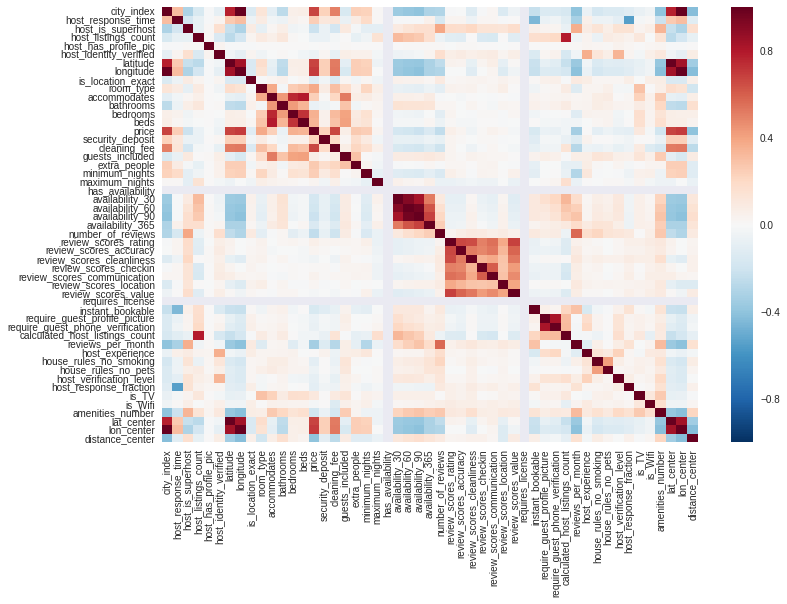

In [76]:
plt.figure(figsize=(12,8))
sns.heatmap(all_listings.corr());
plt.show()

# (**Q1**) what are the positive and negative reviews?

The field of our interest is `comments` that contains the textual comments. To trasform it into review sentiments (to answer **Q1**), I will use the publicly available pre-trained [Vader sentiment model based on NLTK](http://www.nltk.org/_modules/nltk/sentiment/vader.html) ([here](http://www.nltk.org/howto/sentiment.html) is the detailed usage example):

In [77]:
test_sentence_1 = 'Room was nice. Room was not awful at all. I really liked it.'
test_sentence_2 = 'I detest this room. It was terrible. I will not stay there any longer.'

vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']

vader_polarity_compound(test_sentence_1), vader_polarity_compound(test_sentence_2)

(0.8112, -0.4767)

As expected, the sentiment score 1 is quite high and sentiment score 2 is rather low (note that positive reviews are scored up to +1 and negative reviews are scores down to -1).

We also see that there are some null comments in these datasets:

In [78]:
seattle_reviews.comments.isnull().sum(), \
boston_reviews.comments.isnull().sum(), \
copenhagen_reviews.comments.isnull().sum()

(360, 198, 302)

Becase it is unclear what the null comment should be, it is natural to drop these rows:

In [79]:
seattle_reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
boston_reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
copenhagen_reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)

seattle_reviews.comments.isnull().sum(), \
boston_reviews.comments.isnull().sum(), \
copenhagen_reviews.comments.isnull().sum()

(0, 0, 0)

Final sentiment polarity calculation for 845k entries takes about 2 hours. To briefly reproduce the result, I saved the updated dataframes in [hdf5](https://support.hdfgroup.org/HDF5/) format:

In [80]:
# %%time

# seattle_reviews['polarity'] = seattle_reviews.comments.map(vader_polarity_compound)
# seattle_reviews.to_hdf('seattle_reviews.h5', key='seattle_reviews', mode='w')

# boston_reviews['polarity'] = boston_reviews.comments.map(vader_polarity_compound)
# boston_reviews.to_hdf('boston_reviews.h5', key='boston_reviews', mode='w')

# copenhagen_reviews['polarity'] = copenhagen_reviews.comments.map(vader_polarity_compound)
# copenhagen_reviews.to_hdf('copenhagen_reviews.h5', key='copenhagen_reviews', mode='w')

! ls -lh *_reviews.h5

-rw-r--r-- 1 dima806 dima806  58M Sep 25 16:33 boston_reviews.h5
-rw-r--r-- 1 dima806 dima806 109M Sep 25 17:57 copenhagen_reviews.h5
-rw-r--r-- 1 dima806 dima806 114M Sep 25 17:16 seattle_reviews.h5


In [81]:
seattle_reviews = pd.read_hdf('seattle_reviews.h5', 'seattle_reviews')
boston_reviews = pd.read_hdf('boston_reviews.h5', 'boston_reviews')
copenhagen_reviews = pd.read_hdf('copenhagen_reviews.h5', 'copenhagen_reviews')
copenhagen_reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
0,6983,8985,2009-09-04,31133,Jeff,"Convenient location, clean apartment, great br...",0.9322
1,6983,9199,2009-09-07,11472,Andrea,We really enjoyed staying to Simon in our firs...,0.9256
2,6983,11763,2009-09-28,35317,Jeanine,"Friendly host, save neighbourhood, clean appar...",0.9432
3,6983,20616,2009-12-17,53151,Sonja,"Simon is great! Fantastic place to stay, supe...",0.9606
4,6983,23168,2010-01-04,50856,James,"Great bed, clean apartment, comfy bed, accomod...",0.9041


Plotting the histogram of review intensities reveals the following peculiarities:
* huge asymmetry between positive and negative reviews, 80+ k of them (or almost 50%) are close to maximally positive (`polarity > 0.92`);
* prominent peak of ~10k 'neutral' reviews.

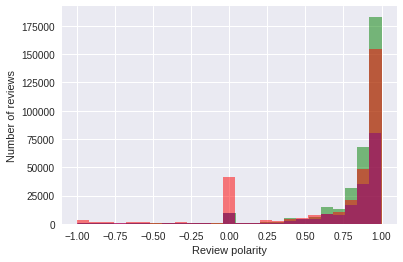

In [82]:
plt.hist(seattle_reviews.polarity, bins=25, color='g', alpha=0.5)
plt.hist(boston_reviews.polarity, bins=25, color='b', alpha=0.5)
plt.hist(copenhagen_reviews.polarity, bins=25, color='r', alpha=0.5)
plt.xlabel('Review polarity')
plt.ylabel('Number of reviews')
plt.show()

Importantly, very small fraction (`< 5%`) of all reviews of our interest are negative:

In [83]:
(seattle_reviews.polarity.values < -0.05).mean(), \
(boston_reviews.polarity.values < -0.05).mean(), \
(copenhagen_reviews.polarity.values < -0.05).mean()

(0.012539823395062627, 0.02678717418147169, 0.0465029255681045)

Let us look on their distribution in more details:

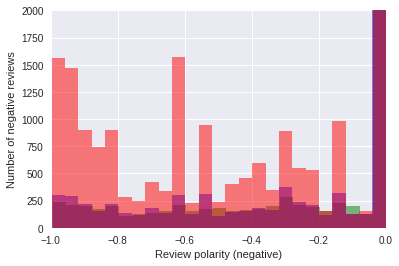

In [84]:
plt.hist(seattle_reviews.polarity, bins=50, color='g', alpha=0.5)
plt.hist(boston_reviews.polarity, bins=50, color='b', alpha=0.5)
plt.hist(copenhagen_reviews.polarity, bins=50, color='r', alpha=0.5)
plt.xlim([-1.00, 0.00])
plt.ylim([0, 2000])
plt.xlabel('Review polarity (negative)')
plt.ylabel('Number of negative reviews')
plt.show()

As we see, the negative review structure is Boston, Seattle in Copenhagen is quite similar, alhough in Copenhagen some broad and narrow peaks (such as very negative reviews with `polarity < -0.8`) are much more pronounced.

In [85]:
(seattle_reviews.polarity.values < -0.8).mean(), \
(boston_reviews.polarity.values < -0.8).mean(), \
(copenhagen_reviews.polarity.values < -0.8).mean()

(0.0028949244264703743, 0.006681288445599652, 0.01723796682294437)

In [86]:
def show_most_common_duplicates(df, top_number=3):
    res = list(Counter(df.polarity.values).most_common(top_number))
    return [(i[0], i[1]/df.shape[0]) for i in res] # returns value and its occurence frequency

In [87]:
show_most_common_duplicates(seattle_reviews), \
show_most_common_duplicates(boston_reviews), \
show_most_common_duplicates(copenhagen_reviews)

([(0.0, 0.027567245166639998),
  (0.6249, 0.013703612109221571),
  (0.6588, 0.0093714086207649)],
 [(0.0, 0.05343903112860212),
  (0.6249, 0.01719656519753497),
  (0.6588, 0.010470171007154899)],
 [(0.0, 0.12667153230495182),
  (0.5994, 0.00689333118915375),
  (0.2732, 0.006265540147700986)])

As we see, for all datasets the top unique review polarity is `0.0`. Also, there is a large variations between cities for its apparent frequency - while for Seattle it is only `2.8%`, for Copenhagen it is as much as `12.7%`.

Look closer for reviews with polarity `0.0`:

In [88]:
copenhagen_reviews[copenhagen_reviews.polarity == 0.0].comments.head(30)

22     Simon est gentil, il habite dans un très joli ...
24     Det var herligt at bo Simon, godt centralt ste...
51     Gutterne var meget hjælpsom og rare. Huset var...
65     Nous avons passé un bon séjour. La chambre est...
81     Simón y su novia son excelentes anfitriones el...
97                                     Très bon accueil!
98     Simon ist ein hilfsbereiter und entspannter Ga...
110                                           tusen tak!
128    Ihana ja moderni asunto lähellä keskustaa. Sim...
143    The host canceled this reservation 19 days bef...
149            Bra beliggenhet og et koselig sted å være
155    The host canceled this reservation 51 days bef...
208    Wirklich im Herzen von Copenhagen. Dadurch lei...
224    The reservation was canceled 11 days before ar...
259    Excellente situation de la maison.\r\nService ...
286    Fin leilighet med flere sengeplasser, lå nært ...
296    Siamo stati a Copenhagen soltanto pochi giorni...
300    Erittäin ystävällinen yh

Not surprisingly, most of such reviews are written in languages different from English (e.g. French, German, Spanish, Danish), so it is natural that Copenhagen, being a European city very attractive for foreign tourists, has more comments on foreign languages than Boston or Seattle.

Other comments made in English, such as `'The host canceled ...'` or `'The reservation was canceled ...'`, are probably automatic messages generated by the system.

In [89]:
def zero_technical_reviews(df):
    res1 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    return (res1+res2)/df.shape[0]

zero_technical_reviews(seattle_reviews), \
zero_technical_reviews(boston_reviews), \
zero_technical_reviews(copenhagen_reviews)

(0.005917865611498233, 0.00888583172174266, 0.035276908422914685)

As we see, **the technical messages fraction about apartment cancellation in Copenhagen 4-6 times larger than in Boston and Seattle**!

Note also that although most of such technical messages are identified with score `0.0`, some of them are not:

In [90]:
def nonzero_technical_reviews(df):
    res1 = df[df.polarity != 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity != 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    return (res1+res2)/df.shape[0]

nonzero_technical_reviews(seattle_reviews), \
nonzero_technical_reviews(boston_reviews), \
nonzero_technical_reviews(copenhagen_reviews)

(2.0366302497781528e-05, 3.3829308585314695e-05, 0.0001422580685065377)

In addition, there is a small fraction of other reviews that are likely to be misidentified by the system, for example:

In [91]:
boston_reviews[boston_reviews.polarity == 0.0].loc[145,:]

listing_id                                                    6695
id                                                       221743420
date                                                    2017-12-27
reviewer_id                                              135126263
reviewer_name                                               Olivia
comments         It's a really decent apartment！Love living her...
polarity                                                         0
Name: 145, dtype: object

What about very negative reviews? First, look into the Copenhagen dataset:

In [92]:
list(copenhagen_reviews[copenhagen_reviews.polarity < -0.8].comments.head())

['Unser Aufenthalt in Simons Apartment war sehr angenehm. Das Zimmer ist gemütlich und die Innenstadt ist von dort aus gut zu Fuß erreichbar. Simon und sein Mitbewohner sind sehr nett und gastfreundlich. Leider konnten wir Simon nicht persönlich kennen lernen, er hat uns aber vorher kontaktiert und sich um alles Wichtige gekümmert, sowie uns Reiseführer mit vielen Tipps hinterlassen.',
 'Der Aufenthalt bei Simon und Singe war super. Simon ist ein sehr freundlicher Gastgeber, wir haben uns sehr schnell wie zuhause gefühlt. \nDas Zimmer ist klein, aber wer nur zum schlafen zuhause ist, hat damit kein Problem. Das Fenster zeigt auf die Parkseite des Gebäudes, sodass man schö bei Fenster offen schlafen kann. Die Wohnung selbst ist wunderschön und liebevoll eingerichtet, das Bad geräumig. Morgens haben wir bei Simon gefrühstückt, was kein Problem für ihn war. Wir haben einen Platz im Kühlschrank bekommen und konnten so gemütlich in den Tag starten. Die Matratze war super bequem, trotz 2 Per

In fact, all these negatively classified reviews are in German, and have very positive tone.

Let us look to Boston and Seattle, then:

In [93]:
list(boston_reviews[boston_reviews.polarity < -0.8].comments.head())

["The penthouse apt. was very nice. However, the elevator wasn't working, and we had to climb 6 flights (4 times, as it ended up). That can happen. However there were other problems that a checklist would have corrected. The cooling did not work until an air conditioning contractor was called (the apt was in the 80s when we arrived after climbing stairs). First, the thermostat in the LR didn't control the cooling, though the sign on it warned against setting it too low. We later were told the cooling was controlled by a thermostat behind the front door, in a closet or niche, but it was inoperable because the battery needed replacement. There was no bath or hand soap, an omission we did not discover until we were ready to shower -- then an 8 block walk to buy soap. The coffeemaker is broken (line that distributes hot water to the grounds was missing); the filters provided were the wrong type (we poured boiling water manually); the toaster oven on/off knob was missing; remote controls on

In [94]:
list(seattle_reviews[seattle_reviews.polarity < -0.8].comments.head())

["Greatly enjoyed our quick stay here. We booked the same day or the day before and they happened to have the room available and check in and everything was a breeze. They do have a couple other rooms that had other airbnber's occupying it at the time and the room next door to us was occupied by a family member. The room is very roomy and plenty of space as well as the restroom. The location is kind of on a busy street and you do get the noise if you choose to leave your window open but that didn't seem to be much of a problem for us. The view at sunrise is to die for and I suggest waking up even if just to go back to sleep to see it!",
 'Had basic amenities. Maddy answered our concerns right away.  The bus stop is right across the street to get to downtown.  Unfortunately, there is no central air and we were there when it was quite hot so it was uncomfortable.  The area was a bit sketchy.',
 'Wallingford war uns sofort sympathisch. Alle Gärten und Häuser sind liebevoll gestaltet und w

Here, in addition to misclassified reviews in German, are some reviews in English with different (positive, negative or neutral) polarity that can also be interpreted as the model misinterpretation.

Finally, let us investigate the most positive reviews:

In [95]:
list(boston_reviews[boston_reviews.polarity > 0.9993].comments)

["Mekkin (pronounced McKeen) met me somewhat late in the evening. Very nice of her to stay up and show me around. The room was great, very comfortable bed, and was really impressed with what they are doing inside. (They have an old 3 story Victorian style home they are renovating. The bathrooms, kitchen, and some of the bedrooms have been redone and are beautiful, and the rest are sure to follow. Don't be fooled by the outside appearance of the house. The inside of the house is great, and only getting better!) Her husband, Rashiek (sp?)  is a great guy! Really friendly, and helpful with suggestions with transit  questions, places to eat, or things to do. (He is kind of the social one, and Mekkin is very nice, but she stays to herself a bit more.) They have a dog that looks imposing, but is a SWEETHEART, once she smells you, once you get introduced to her. (yeah, she is REALLY imposing the way she rolls on her back and wants you to rub her tummy :-)\r\n\r\nI was visiting my daughter, wh

In [96]:
list(seattle_reviews[seattle_reviews.polarity > 0.9996].comments)

['Awesome location about a mile from downtown Ballard with tons of cute places to visit.  I did brewery and distillery tours and lots of gift shopping for the holidays.  Lara also lent me a great bike that got me super easily over to the Fremont area as well, where there is more of the same- great restaurants etc.  The bike trail (Burke-Gilman) is just at the bottom of the hill from the house which is in a very nice quiet neighborhood.  I did not ride super far on the trail, but apparently it is quite long and will take you to tons of great Seattle spots!  \r\n\r\nThe room itself is more than a room- has its own bathroom, kitchenette and everything I would need if I wanted a totally private stay.  Pretty much the entire downstairs to the whole house is all yours.  Very clean and comfortable with a fun tiki theme.  It was raining when I was up there and somewhat cold, but I was plenty warm and cozy in the space and Lara left out extra blankets just in case.  As it was wet outside, I did

In [97]:
list(copenhagen_reviews[copenhagen_reviews.polarity > 0.9994].comments)

['Everything was very good. According to discription and very friendly host. Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good! Very good!

As we see, all top positive reviews are indeed very positive.

To summarize **Q1**, publicly available pre-trained [Vader sentiment model based on NLTK](http://www.nltk.org/_modules/nltk/sentiment/vader.html) is used to predict the sentiment polarity of recent reviews for Airbnb listings from Boston (MA, USA), Seattle (WA, USA) and Copenhagen (Denmark, EU). The model describes the sentiment polarity of English-written reviews fairly well but does not generalise for other common languages (German, French, Spanish etc.). As expected, the majority (95+% of all reviews) are positively- or neutrally-classified, and the large part of negatively- and neutrally-classified reviews are in fact misclassified positive reviews written in other languages. In addition to that, a subdominant part of neutrally-classified reviews are the typical technical messages due to host cancellation. Interestingly, **the fraction of such technical messages in Copenhagen is quite big, 3.5%, or 4-6 times larger than in Boston and Seattle**. This seems odd and may deserve further detailed investigation.

# **(Q2)** what are the main distinctions of Airbnb superhosts from ordinary hosts?

Frist, we calculate the fraction of superhosts in each city:

In [98]:
all_listings.groupby('city_index').agg(np.mean)['host_is_superhost']

city_index
1    0.395308
2    0.226783
3    0.099771
Name: host_is_superhost, dtype: float64

As we see, **Copenhagen (3) has significantly smaller fraction of superhosts than Seattle (1) or Boston (2)**. This **may be related** to one of the results in **Q1** that **Copenhagen has much larger number of review messages containing host apartment cancellations**.

Then, we calculate [t-test statistics](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) in order to understand the significant differences between the results. In our samples, both sample sizes and variances are unequal, so we used [Welsh's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test).
Also, it is important to drop all NaN values when calculating t-test, it is done with [pandas.Series.dropna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dropna.html).

Usually, the lower `p-value`, the more significant difference between two datasets. There are different possible thresholds for `p-value` used in literature corresponding to a significant difference bewteen the datasets, e.g. `1%`, `5%` or `10%`. The sign of t-test statistics shows which value is larger in average.

In [99]:
def superhost_significances(df, threshold = 0.01):
    df_t = df[df.host_is_superhost == 1]
    df_f = df[df.host_is_superhost == 0]
    res = pd.Series()
    # calculate ttest statistics and p-values for each column
    for col in df.columns:
        t_test, p_val = stats.ttest_ind(df_t[col].dropna(), df_f[col].dropna(), equal_var = False)
        # show only columns with p-value < threshold
        if p_val < threshold:
            res[col] = (t_test, p_val)
    return res.sort_values(ascending=False)

In [100]:
superhost_significances(all_listings[all_listings.city_index == 1]) # Seattle

host_is_superhost                                                       (inf, 0.0)
amenities_number                       (31.700115453729484, 9.57580576241241e-205)
number_of_reviews                     (28.764069899492302, 2.389779843741284e-168)
review_scores_rating                   (26.52043907420906, 4.286790124926522e-146)
reviews_per_month                      (25.19407820932703, 9.123270625368777e-134)
review_scores_value                   (24.886780755588834, 9.269644288912752e-131)
review_scores_accuracy                (23.40677904807568, 1.0616070795675122e-115)
review_scores_cleanliness             (23.391680768315425, 3.358553127552447e-116)
host_identity_verified                  (18.48926818540581, 1.415127964523318e-74)
review_scores_communication            (18.17402436686198, 1.3899599796358734e-71)
review_scores_checkin                 (17.546968734851646, 5.5744634783370434e-67)
review_scores_location                 (13.560281743406545, 2.301945285420604e-41)
host

In [101]:
superhost_significances(all_listings[all_listings.city_index == 2]) # Boston

host_is_superhost                                                      (inf, 0.0)
review_scores_rating                (26.592625979939733, 1.0417234442929131e-144)
review_scores_cleanliness             (25.45740315110126, 1.983773871810968e-133)
review_scores_accuracy                (24.68942778294737, 3.330439000264772e-126)
review_scores_value                   (23.35158490248464, 8.698966252109741e-113)
review_scores_communication          (23.244331147866667, 2.350735050152552e-112)
number_of_reviews                     (20.608042205246303, 2.985961353695486e-83)
review_scores_checkin                  (20.60590533852608, 8.079220728753538e-90)
reviews_per_month                    (19.557741148178994, 2.1655228949234753e-77)
amenities_number                      (18.22657637259726, 2.8169127040045863e-68)
host_response_fraction                 (14.02783064938336, 8.752546749611347e-44)
house_rules_no_smoking                  (12.2367235583858, 4.692004068485672e-33)
host_identity_ve

In [102]:
superhost_significances(all_listings[all_listings.city_index == 3]) # Copenhagen

host_is_superhost                                                    (inf, 0.0)
number_of_reviews                  (33.240198549296856, 3.266915089694422e-200)
review_scores_rating              (33.177248410783065, 1.3149581306488886e-226)
review_scores_accuracy             (33.12243350273923, 2.5609526810787566e-224)
review_scores_cleanliness          (29.84199543958598, 1.8650635113521827e-180)
reviews_per_month                 (28.239883454854795, 1.1449153958122792e-153)
review_scores_communication        (27.69810014467264, 2.0622744577899896e-163)
review_scores_checkin              (25.512153377697473, 6.395713270945861e-138)
amenities_number                  (24.454460424432902, 1.7496532880031637e-119)
host_response_fraction             (23.04775829969133, 1.4158600398860478e-113)
lat_center                         (21.514424859813648, 1.1547634960183334e-96)
review_scores_value                (18.631952806283252, 2.7016415357311192e-74)
host_verification_level              (17

As we see, for all three locations (Boston, Seattle and Copenhagen), superhosts tend to have larger total and monthly averaged number of reviews (`number_of_reviews` and `reviews_per_month`), review scores (`review_scores_*`) and yearly availability (`availability_365`) are larger for superhosts than for ordinary hosts. On the other hand, the number of minimum nights (`minimum_nights`), host response time (`host_response_time`) and the host listings counts (`host_listings_count`, `calculated_host_listings_count`) are smaller for superhosts than for ordinary hosts. This may reflect the higher popularity of superhosts and their higher level of service, compared to ordinary hosts.

Also, there are several notable distinctions between different locations. While for Boston and Seattle the monthly availability (`availability_30`) is smaller for superhosts, for Copenhagen it is significantly higher than for ordinary hosts. Secondly, for Seattle and Copenhagen superhosts afford significantly less `bedrooms` while for Boston the difference is not significant. In Copenhagen, it is also significantly smaller `accomodates` for superhosts while for Boston and Seattle the difference is not significant.

# **(Q3)** what are the main factors that influence Airbnb renting price?

To answer this question, we will model the renting price with [`GradientBoostingRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) and study [`PermutationImportance`](https://www.kaggle.com/dansbecker/permutation-importance) of every feature. Note that we exclude several features (`longitude`, `latitude`, `cleaning_fee`, `extra_people`, `security_deposit`, `city_index`) from this analysis:

In [103]:
data = all_listings.dropna(axis=0, how='any')

Interestingly, for different cities, the distribution of permutation weights is very different!!!

For all three cities combined, the result is as follows:

In [104]:
y = data['price']
X = data.drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude', 'city_index'], axis=1) #, 
#                
#               ,
#               'city_index'], 
#              axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [105]:
# regr = GradientBoostingRegressor(random_state=42)
# param_dist = {"max_depth": stats.randint(2, 6),
#               "n_estimators": stats.randint(50, 200),
#               "learning_rate": Real(10**-1, 10**0, "log-uniform", name='learning_rate')} #,
# #              "subsample": stats.uniform(0.5, 0.5)}

# n_iter_search = 50
# random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=3, verbose=2)

# random_search.fit(X, y)
# print(random_search.best_score_, random_search.best_estimator_)

First, we tune the parameters of the best `GradientBoostingRegressor` model:

In [106]:
%%time 
regr = GradientBoostingRegressor(n_estimators=75, learning_rate=0.31, max_depth=4, subsample=1.0,
                                 random_state=42)
regr.fit(X_train, y_train)
print(r2_score(y_val, regr.predict(X_val)))

0.7880908555643148
CPU times: user 2.22 s, sys: 13.9 ms, total: 2.23 s
Wall time: 2.27 s


R2 score is quite decent (0.788), so we apply this model to calculate `PermutationImportance` of different features:

In [107]:
perm = PermutationImportance(regr, random_state=42).fit(X_val, y_val)
eli5.show_weights(perm, top=X.shape[1], feature_names = X.columns.tolist())

Weight,Feature
0.4784 ± 0.0329,cleaning_fee
0.0910 ± 0.0040,distance_center
0.0580 ± 0.0062,extra_people
0.0565 ± 0.0053,security_deposit
0.0534 ± 0.0072,bedrooms
0.0324 ± 0.0063,room_type
0.0253 ± 0.0032,host_listings_count
0.0160 ± 0.0033,availability_365
0.0154 ± 0.0052,availability_60
0.0151 ± 0.0021,availability_90


Interestingly, `cleaning_fee` appears to be the most important feature. Next-to-largest-important features are `distance_center`, `extra_people`, `security_deposit`, `bedrooms`, as expected.

Let us then compare model predictions for different cities:

In [108]:
y1 = data[data.city_index == 1]['price']
X1 = data[data.city_index == 1].drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude'], 
                                     axis=1)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, random_state=42)

y2 = data[data.city_index == 2]['price']
X2 = data[data.city_index == 2].drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude'], 
                                     axis=1)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, random_state=42)

y3 = data[data.city_index == 3]['price']
X3 = data[data.city_index == 3].drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude'], 
                                     axis=1)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, random_state=42)

In [109]:
%%time
regr1 = GradientBoostingRegressor(n_estimators=125, learning_rate=0.30, max_depth=8, random_state=42)
regr1.fit(X1_train, y1_train)
regr2 = GradientBoostingRegressor(n_estimators=135, learning_rate=0.24, max_depth=5, random_state=42)
regr2.fit(X2_train, y2_train)
regr3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.26, max_depth=2, random_state=42)
regr3.fit(X3_train, y3_train)
print(regr1.score(X1_val, y1_val), regr2.score(X2_val, y2_val), regr3.score(X3_val, y3_val))

0.6367146107515768 0.6052438418591303 0.5929277292760825
CPU times: user 4.84 s, sys: 0 ns, total: 4.84 s
Wall time: 4.84 s


In [110]:
perm1 = PermutationImportance(regr1, random_state=42).fit(X1_val, y1_val)
eli5.show_weights(perm1, top=X1.shape[1], feature_names = X1.columns.tolist())

Weight,Feature
0.1203 ± 0.0353,cleaning_fee
0.0816 ± 0.0268,distance_center
0.0749 ± 0.0024,bedrooms
0.0626 ± 0.0240,room_type
0.0619 ± 0.0172,host_listings_count
0.0618 ± 0.0328,accommodates
0.0263 ± 0.0057,security_deposit
0.0254 ± 0.0101,availability_30
0.0196 ± 0.0126,guests_included
0.0179 ± 0.0082,number_of_reviews


In [111]:
perm2 = PermutationImportance(regr2, random_state=42).fit(X2_val, y2_val)
eli5.show_weights(perm2, top=X2.shape[1], feature_names = X2.columns.tolist())

Weight,Feature
0.2675 ± 0.0657,host_listings_count
0.1421 ± 0.0336,cleaning_fee
0.1138 ± 0.0478,number_of_reviews
0.0737 ± 0.0294,distance_center
0.0723 ± 0.0566,reviews_per_month
0.0589 ± 0.0142,room_type
0.0544 ± 0.0208,availability_30
0.0436 ± 0.0165,bathrooms
0.0429 ± 0.0130,security_deposit
0.0367 ± 0.0111,review_scores_rating


In [112]:
perm3 = PermutationImportance(regr3, random_state=42).fit(X3_val, y3_val)
eli5.show_weights(perm3, top=X3.shape[1], feature_names = X3.columns.tolist())

Weight,Feature
0.1420 ± 0.0220,bedrooms
0.1164 ± 0.0109,room_type
0.1016 ± 0.0162,distance_center
0.0422 ± 0.0060,accommodates
0.0387 ± 0.0122,cleaning_fee
0.0342 ± 0.0057,availability_30
0.0217 ± 0.0060,extra_people
0.0170 ± 0.0029,availability_365
0.0137 ± 0.0023,guests_included
0.0097 ± 0.0020,review_scores_location


As we see, there are significant differences between largest influencing features between different cities. For example, `hosting_listings_count` is valuable for US cities (especially for Boston) but is negligible for Copenhagen. On the other hand, `distance_center` and `room_type` are among the most important features for price prediction in every city of our interest, as expected.

# **(Q4)** how well can we predict the Airbnb renting price based on the data from a different city?

To answer this question, I implement manual cross-validation: we will test the model based on data on two cities and validate the model on remaining one. Clearly, `lat_center`, `lon_center`, `longitude`, `latitude` columns should be dropped:

In [113]:
y12 = data[data.city_index != 3]['price']
X12 = data[data.city_index != 3].drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude', 'city_index'], 
                                     axis=1)
X12_train, X12_val, y12_train, y12_val = train_test_split(X12, y12, random_state=42)

y13 = data[data.city_index != 2]['price']
X13 = data[data.city_index != 2].drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude', 'city_index'], 
                                     axis=1)
X13_train, X13_val, y13_train, y13_val = train_test_split(X13, y13, random_state=42)

y23 = data[data.city_index != 1]['price']
X23 = data[data.city_index != 1].drop(['price', 'lat_center', 'lon_center', 'longitude', 'latitude', 'city_index'], 
                                     axis=1)
X23_train, X23_val, y23_train, y23_val = train_test_split(X23, y23, random_state=42)

In [114]:
%%time
regr12 = GradientBoostingRegressor(n_estimators=120, learning_rate=0.30, max_depth=8, random_state=42)
regr12.fit(X12_train, y12_train)
regr23 = GradientBoostingRegressor(n_estimators=130, learning_rate=0.26, max_depth=5, random_state=42)
regr23.fit(X23_train, y23_train)
regr13 = GradientBoostingRegressor(n_estimators=105, learning_rate=0.26, max_depth=4, random_state=42)
regr13.fit(X13_train, y13_train)
print(np.mean([regr13.score(X13_val, y13_val), 
               regr12.score(X12_val, y12_val), 
               regr23.score(X23_val, y23_val)]))

0.6967172981430158
CPU times: user 11.1 s, sys: 6.18 ms, total: 11.2 s
Wall time: 11.2 s


As we see, final [`R2 score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) is quite good (0.697) for such a simple model.